
# Tesla Stock Forecasting — ARIMA/SARIMA vs Multivariate LSTM

This notebook builds, evaluates, and compares:
- **ARIMA/SARIMA** on the univariate **Close** series
- **Multivariate LSTM** using **[Open, High, Low, Close, Volume]** and optional **technical indicators**

It follows a chronological split (e.g., **train: 2015–2023**, **test: 2024–2025**).
Metrics: **MAE, RMSE, MAPE**. Plots show actual vs. forecasts.

> Note: ARIMA is univariate by design here; LSTM is multivariate. SARIMA can be toggled on/off.


## 1) Setup & Configuration

In [2]:

# Install (run only if needed)
# !pip install pandas numpy matplotlib scikit-learn pmdarima tensorflow

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple, Optional

# Optional packages
AUTO_ARIMA_AVAILABLE = True
try:
    from pmdarima import auto_arima
except Exception:
    AUTO_ARIMA_AVAILABLE = False

TF_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
except Exception:
    TF_AVAILABLE = False

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.random.seed(42)

# ==== Config (edit here) ====
DATA_PATH = "/content/drive/MyDrive/week11/data/raw/TSLA.csv"   # e.g., "data/tesla_daily.csv"
DATE_COL = "Date"
TARGET_COL = "Close"

TRAIN_START = "2015-01-01"
TRAIN_END   = "2023-12-31"
TEST_START  = "2024-01-01"
TEST_END    = "2025-12-31"

# SARIMA toggle and period (m=5 for trading-week seasonality)
USE_SEASONAL = False
M_SEASONAL   = 5

# LSTM hyperparams
LOOKBACK     = 60
LSTM_UNITS   = 64
LSTM_DROPOUT = 0.2
BATCH_SIZE   = 32
EPOCHS       = 30
PATIENCE     = 5
LEARNING_RATE= 1e-3

# Technical indicators toggle
USE_TECHNICALS = True


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) Utilities

In [3]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # Removed squared=False
    rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

def load_series_df(data_path: str, date_col: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    if date_col not in df.columns:
        raise ValueError(f"Expected date column '{date_col}' in CSV.")
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).set_index(date_col)
    # Reindex to business days
    df = df.asfreq("B")
    # Forward/Backward fill small gaps
    df = df.ffill().bfill()
    return df

def chronological_split_indexed(s: pd.Series, train_start, train_end, test_start, test_end):
    train = s.loc[train_start:train_end]
    test  = s.loc[test_start:test_end]
    if len(train) == 0 or len(test) == 0:
        raise ValueError("Train/test period produced empty slices. Adjust dates.")
    return train, test

def make_supervised_multivariate(arr_2d: np.ndarray, lookback: int):
    # arr_2d shape: (time, features)
    X, y = [], []
    for i in range(lookback, arr_2d.shape[0]):
        X.append(arr_2d[i-lookback:i, :])
        y.append(arr_2d[i, 0])  # predict Close (assumed column 0 after selection below)
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y

## 3) Load & Inspect Data

In [4]:

df = load_series_df(DATA_PATH, DATE_COL)
print("Columns:", list(df.columns))
display(df.head())
display(df.describe())


Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.94333267211914,18.174667358398438,17.856666564941406,18.073999404907227,31518000
2015-07-02,18.667999267578125,18.829999923706055,18.220666885375977,18.68000030517578,107458500
2015-07-03,18.667999267578125,18.829999923706055,18.220666885375977,18.68000030517578,107458500
2015-07-06,18.648000717163086,18.779333114624023,18.420000076293945,18.591999053955078,61828500
2015-07-07,17.858667373657227,18.34666633605957,17.384666442871094,18.333332061767578,91576500


,Close,High,Low,Open,Volume
count,2631,2631,2631,2631,2631
unique,2482,2428,2447,2429,2525
top,14.433333396911621,20.53333282470703,23.46666717529297,24.0,204750000
freq,3,4,4,4,2


## 4) Feature Engineering (Technicals)

In [5]:
# We'll build LSTM inputs from: [Close, Open, High, Low, Volume] by default
# (We'll reorder columns so Close is first for convenience)
base_cols = ["Close", "Open", "High", "Low", "Volume"]
available = [c for c in base_cols if c in df.columns]
if "Close" not in available:
    raise ValueError("Column 'Close' must be present for both ARIMA and LSTM targets.")
# Ensure Close is first
available = ["Close"] + [c for c in available if c != "Close"]

fe_df = df.copy()

# Convert relevant columns to numeric, coercing errors
for col in available:
    fe_df[col] = pd.to_numeric(fe_df[col], errors='coerce')

if USE_TECHNICALS:
    # Simple technicals: SMAs, EMAs, RSI, MACD
    # SMAs
    for w in [5, 10, 20]:
        fe_df[f"SMA_{w}"] = fe_df["Close"].rolling(w).mean()
    # EMAs
    for w in [12, 26]:
        fe_df[f"EMA_{w}"] = fe_df["Close"].ewm(span=w, adjust=False).mean()
    # RSI (14)
    delta = fe_df["Close"].diff()
    gain = (delta.clip(lower=0)).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / (loss + 1e-8)
    fe_df["RSI_14"] = 100 - (100 / (1 + rs))
    # MACD (12,26,9)
    ema12 = fe_df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = fe_df["Close"].ewm(span=26, adjust=False).mean()
    fe_df["MACD"] = ema12 - ema26
    fe_df["MACD_Signal"] = fe_df["MACD"].ewm(span=9, adjust=False).mean()

# Drop warm-up NaNs from indicators and any NaNs created by coercion
fe_df = fe_df.dropna()

print("Engineered columns:", len(fe_df.columns))
display(fe_df.head())

Engineered columns: 13


,Close,High,Low,Open,Volume,SMA_5,SMA_10,SMA_20,EMA_12,EMA_26,RSI_14,MACD,MACD_Signal
Date,,,,,,,,,,,,,
2015-07-28,17.654667,17.693333,16.789333,17.049999,58437000,17.577467,17.812133,17.828167,17.707792,17.801795,56.522890,-0.094003,-0.047091
2015-07-29,17.587999,17.859333,17.466667,17.618000,41851500,17.523466,17.816667,17.810400,17.689363,17.785958,54.007044,-0.096596,-0.056992
2015-07-30,17.785999,17.796000,17.474001,17.512667,30519000,17.518000,17.817400,17.766300,17.704230,17.785961,55.068994,-0.081731,-0.061940
2015-07-31,17.743334,17.957333,17.674667,17.840000,33339000,17.527866,17.760666,17.720067,17.710246,17.782804,52.733258,-0.072558,-0.064063
2015-08-03,17.332666,17.780666,17.138000,17.752666,38302500,17.620933,17.612200,17.654300,17.652157,17.749460,46.259588,-0.097303,-0.070711


## 5) Chronological Split (Train/Test)

In [6]:

# Univariate target series for ARIMA/SARIMA
target = fe_df[TARGET_COL]

train_y, test_y = chronological_split_indexed(target, TRAIN_START, TRAIN_END, TEST_START, TEST_END)
print(f"Train len: {len(train_y)}, Test len: {len(test_y)}")

# Multivariate features for LSTM: Keep Close first, then others + technicals (if enabled)
feature_cols = [c for c in fe_df.columns if c in available]  # Close, Open, High, Low, Volume present
# Append technicals if any
extra_cols = [c for c in fe_df.columns if c not in feature_cols]
feature_cols = feature_cols + extra_cols

feat_train = fe_df.loc[TRAIN_START:TRAIN_END, feature_cols].copy()
feat_test  = fe_df.loc[TEST_START:TEST_END,  feature_cols].copy()

print("LSTM features used:", feature_cols[:10], "... (total:", len(feature_cols), ")")
display(feat_train.head())


Train len: 2199, Test len: 413
LSTM features used: ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26'] ... (total: 13 )


,Close,High,Low,Open,Volume,SMA_5,SMA_10,SMA_20,EMA_12,EMA_26,RSI_14,MACD,MACD_Signal
Date,,,,,,,,,,,,,
2015-07-28,17.654667,17.693333,16.789333,17.049999,58437000,17.577467,17.812133,17.828167,17.707792,17.801795,56.522890,-0.094003,-0.047091
2015-07-29,17.587999,17.859333,17.466667,17.618000,41851500,17.523466,17.816667,17.810400,17.689363,17.785958,54.007044,-0.096596,-0.056992
2015-07-30,17.785999,17.796000,17.474001,17.512667,30519000,17.518000,17.817400,17.766300,17.704230,17.785961,55.068994,-0.081731,-0.061940
2015-07-31,17.743334,17.957333,17.674667,17.840000,33339000,17.527866,17.760666,17.720067,17.710246,17.782804,52.733258,-0.072558,-0.064063
2015-08-03,17.332666,17.780666,17.138000,17.752666,38302500,17.620933,17.612200,17.654300,17.652157,17.749460,46.259588,-0.097303,-0.070711


## 6) ARIMA/SARIMA — Fit & Forecast (Univariate Close)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA/SARIMA info: {'order': (2, 1, 2), 'aic': np.float64(13941.05478209339)}
ARIMA/SARIMA metrics: {'MAE': 63.74536718363407, 'RMSE': np.float64(78.91090848584649), 'MAPE%': np.float64(24.22991474073356)}


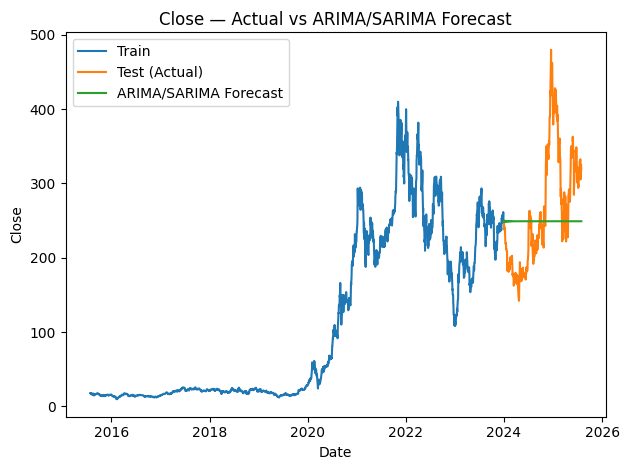

In [7]:
horizon = len(test_y)

if AUTO_ARIMA_AVAILABLE:
    stepwise = auto_arima(
        train_y,
        seasonal=USE_SEASONAL,
        m=(M_SEASONAL if USE_SEASONAL else 1),
        trace=False, error_action="ignore", suppress_warnings=True, stepwise=True,
        information_criterion="aic"
    )
    arima_model = stepwise
    arima_fc = np.array(arima_model.predict(n_periods=horizon))
    arima_info = {"order": getattr(arima_model, "order", None),
                  "seasonal_order": getattr(arima_model, "seasonal_order", None),
                  "aic": getattr(arima_model, "aic", None)}
else:
    from statsmodels.tsa.arima.model import ARIMA
    best_aic = np.inf
    best_model = None
    best_order = None
    for p in [0,1,2,3]:
        for d in [0,1,2]:
            for q in [0,1,2,3]:
                try:
                    res = ARIMA(train_y, order=(p,d,q)).fit()
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_model = res
                        best_order = (p,d,q)
                except Exception:
                    continue
    if best_model is None:
        raise RuntimeError("ARIMA grid search failed for all combinations.")
    arima_model = best_model
    arima_fc = np.array(best_model.forecast(steps=horizon))
    arima_info = {"order": best_order, "aic": best_aic}

print("ARIMA/SARIMA info:", arima_info)
arima_metrics = evaluate(test_y.values, arima_fc)
print("ARIMA/SARIMA metrics:", arima_metrics)

# Plot
plt.figure()
plt.plot(train_y.index, train_y.values, label="Train")
plt.plot(test_y.index, test_y.values, label="Test (Actual)")
plt.plot(test_y.index, arima_fc, label="ARIMA/SARIMA Forecast")
plt.title("Close — Actual vs ARIMA/SARIMA Forecast")
plt.xlabel("Date"); plt.ylabel("Close")
plt.legend(); plt.tight_layout()
plt.show()


## 7) Multivariate LSTM — Fit & Forecast

LSTM metrics: {'MAE': 14.846670364267927, 'RMSE': np.float64(19.6507869282192), 'MAPE%': np.float64(5.519889101562199)}


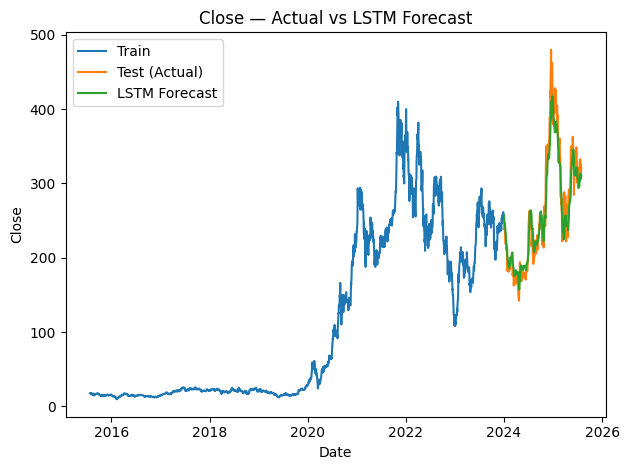

In [8]:

if not TF_AVAILABLE:
    raise RuntimeError("TensorFlow is not available. Please install tensorflow or tensorflow-cpu.")

# Scale features jointly (fit on train only)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(feat_train.values)
test_scaled  = scaler.transform(feat_test.values)

# Build supervised sets from the *continuous* sequence (train only for fitting)
X_train, y_train = [], []
lookback = LOOKBACK

# We build the rolling windows within the *training* period only
for i in range(lookback, train_scaled.shape[0]):
    X_train.append(train_scaled[i-lookback:i, :])
    # y is Close (assume Close is the first column in feature_cols)
    y_train.append(train_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)

model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(lookback, train_scaled.shape[1]), return_sequences=False),
    Dropout(LSTM_DROPOUT),
    Dense(1)
])
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss="mse")

es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1, shuffle=False, verbose=0,
    callbacks=[es]
)

# Recursive forecast across the test horizon
history_seq = np.concatenate([train_scaled, test_scaled[:0]], axis=0)  # just to copy dtype/shape
history_seq = train_scaled.copy()

preds_scaled = []
for i in range(test_scaled.shape[0]):
    # Take the last lookback window from history_seq
    window = history_seq[-lookback:, :]
    window = window.reshape(1, lookback, -1)
    yhat_scaled = model.predict(window, verbose=0)[0, 0]
    preds_scaled.append(yhat_scaled)
    # Append a new row to history_seq where target (Close) is yhat, and other features are from test_scaled[i]
    new_row = test_scaled[i].copy()
    new_row[0] = yhat_scaled  # overwrite Close with the predicted scaled value
    history_seq = np.vstack([history_seq, new_row])

# Inverse transform: we need to put preds back into original scale.
# We'll construct an array with predicted Close and zeros for other features to use scaler.inverse_transform properly.
inv_template = np.zeros((len(preds_scaled), train_scaled.shape[1]))
inv_template[:, 0] = preds_scaled
inv_preds = scaler.inverse_transform(inv_template)[:, 0]

lstm_fc = inv_preds
lstm_metrics = evaluate(test_y.values, lstm_fc)
print("LSTM metrics:", lstm_metrics)

# Plot
plt.figure()
plt.plot(train_y.index, train_y.values, label="Train")
plt.plot(test_y.index, test_y.values, label="Test (Actual)")
plt.plot(test_y.index, lstm_fc, label="LSTM Forecast")
plt.title("Close — Actual vs LSTM Forecast")
plt.xlabel("Date"); plt.ylabel("Close")
plt.legend(); plt.tight_layout()
plt.show()


## 8) Side-by-side Metrics & Combined Plot

,Model,MAE,RMSE,MAPE%
0,ARIMA/SARIMA,63.745367,78.910908,24.229915
1,LSTM (Multivariate),14.846670,19.650787,5.519889


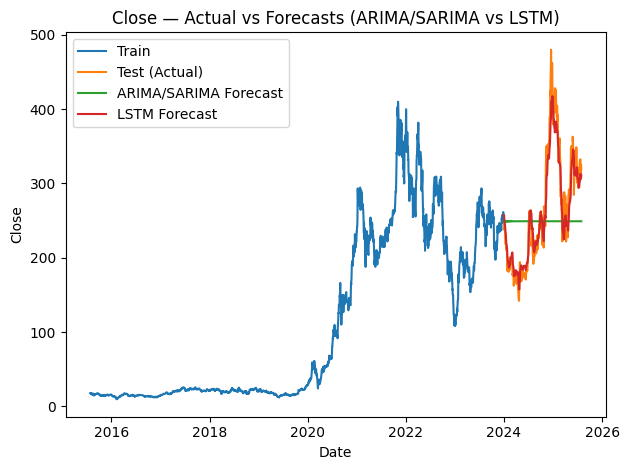

Summary: On this split, LSTM achieved the lower RMSE.


In [9]:

metrics_df = pd.DataFrame([
    {"Model": "ARIMA/SARIMA", **arima_metrics},
    {"Model": "LSTM (Multivariate)", **lstm_metrics},
])
display(metrics_df)

# Combined plot
plt.figure()
plt.plot(train_y.index, train_y.values, label="Train")
plt.plot(test_y.index, test_y.values, label="Test (Actual)")
plt.plot(test_y.index, arima_fc, label="ARIMA/SARIMA Forecast")
plt.plot(test_y.index, lstm_fc, label="LSTM Forecast")
plt.title("Close — Actual vs Forecasts (ARIMA/SARIMA vs LSTM)")
plt.xlabel("Date"); plt.ylabel("Close")
plt.legend(); plt.tight_layout()
plt.show()

# Brief interpretation
better = None
if np.isfinite(metrics_df.loc[0, "RMSE"]) and np.isfinite(metrics_df.loc[1, "RMSE"]):
    better = "ARIMA/SARIMA" if metrics_df.loc[0, "RMSE"] < metrics_df.loc[1, "RMSE"] else "LSTM"

if better:
    print(f"Summary: On this split, {better} achieved the lower RMSE.")
else:
    print("Summary: Could not compute a direct comparison.")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA/SARIMA info: {'order': (2, 1, 2), 'aic': np.float64(13941.05478209339)}
ARIMA/SARIMA metrics: {'MAE': 63.74536718363407, 'RMSE': np.float64(78.91090848584649), 'MAPE%': np.float64(24.22991474073356)}


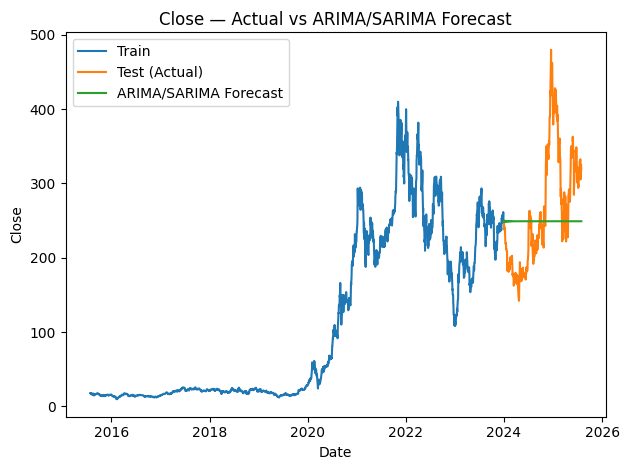

In [10]:
horizon = len(test_y)

if AUTO_ARIMA_AVAILABLE:
    stepwise = auto_arima(
        train_y,
        seasonal=USE_SEASONAL,
        m=(M_SEASONAL if USE_SEASONAL else 1),
        trace=False, error_action="ignore", suppress_warnings=True, stepwise=True,
        information_criterion="aic"
    )
    arima_model = stepwise
    arima_fc = np.array(arima_model.predict(n_periods=horizon))
    arima_info = {"order": getattr(arima_model, "order", None),
                  "seasonal_order": getattr(arima_model, "seasonal_order", None),
                  "aic": getattr(arima_model, "aic", None)}
else:
    from statsmodels.tsa.arima.model import ARIMA
    best_aic = np.inf
    best_model = None
    best_order = None
    for p in [0,1,2,3]:
        for d in [0,1,2]:
            for q in [0,1,2,3]:
                try:
                    res = ARIMA(train_y, order=(p,d,q)).fit()
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_model = res
                        best_order = (p,d,q)
                except Exception:
                    continue
    if best_model is None:
        raise RuntimeError("ARIMA grid search failed for all combinations.")
    arima_model = best_model
    arima_fc = np.array(best_model.forecast(steps=horizon))
    arima_info = {"order": best_order, "aic": best_aic}

print("ARIMA/SARIMA info:", arima_info)
arima_metrics = evaluate(test_y.values, arima_fc)
print("ARIMA/SARIMA metrics:", arima_metrics)

# Plot
plt.figure()
plt.plot(train_y.index, train_y.values, label="Train")
plt.plot(test_y.index, test_y.values, label="Test (Actual)")
plt.plot(test_y.index, arima_fc, label="ARIMA/SARIMA Forecast")
plt.title("Close — Actual vs ARIMA/SARIMA Forecast")
plt.xlabel("Date"); plt.ylabel("Close")
plt.legend(); plt.tight_layout()
plt.show()